In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import os
from IPython.display import Image, display
from matplotlib.patches import Circle
import base64
from io import BytesIO
import pymunk


In [2]:
def run_simulation(initial_state, steps=100, env_size=600):
    # Create the physics space
    space = pymunk.Space()
    space.gravity = (0, -981)  # Set gravity

    # Define boundaries (e.g., a 600x600 box)
    walls = [
        pymunk.Segment(space.static_body, (0, 0), (env_size, 0), 1),
        pymunk.Segment(space.static_body, (env_size, 0), (env_size, env_size), 1),
        pymunk.Segment(space.static_body, (env_size, 600), (0, env_size), 1),
        pymunk.Segment(space.static_body, (0, env_size), (0, 0), 1)
    ]
    for wall in walls:
        wall.elasticity = 0.95  # Coefficient of elasticity for the walls
        space.add(wall)

    # Create objects based on initial state
    objects = {}
    for obj_id, attrs in initial_state.items():
        mass = attrs['mass']
        radius = attrs['radius']
        inertia = pymunk.moment_for_circle(mass, 0, radius)
        body = pymunk.Body(mass, inertia)
        body.position = attrs['location']
        body.velocity = attrs['velocity']
        shape = pymunk.Circle(body, radius)
        shape.elasticity = 0.8  # Adjust elasticity as needed
        space.add(body, shape)
        objects[obj_id] = {'body': body, 'shape': shape}

    # Simulation steps
    timeline = []
    for i in range(steps):
        space.step(1/50.0)  # Advance the simulation
        step_state = {
            'time': i,
            'objects': {}
        }
        # Record the state for each object
        for obj_id, obj in objects.items():
            step_state['objects'][obj_id] = {
                'location': (obj['body'].position.x, obj['body'].position.y),
                'velocity': (obj['body'].velocity.x, obj['body'].velocity.y),
                'radius': obj['shape'].radius,
                'mass': obj['shape'].mass
            }
        timeline.append(step_state)

    return timeline

In [3]:
def generate_initial_state(n_objects, env_size, radius_range, mass_range):
    initial_state = {}
    for i in range(n_objects):
        # Generate random mass and radius within the specified range
        mass = random.uniform(mass_range[0], mass_range[1])
        radius = random.uniform(radius_range[0], radius_range[1])
        
        # Generate a random location within the environment bounds
        location = (random.uniform(radius, env_size - radius), 
                    random.uniform(radius, env_size - radius))
        
        # Initial velocity can be set to zero or randomized if needed
        velocity = (0, 0)  # Set as zero for simplicity, can be randomized
        
        # Store the object's attributes
        initial_state[str(i)] = {
            'mass': mass,
            'radius': radius,
            'location': location,
            'velocity': velocity
        }
    
    return initial_state

In [4]:
def simulation_to_gif(data, env_size, filename='simulation.gif', skip_frames=1):
    # Create a folder to store images temporarily
    if not os.path.exists('frames'):
        os.makedirs('frames')
    
    # Plot each frame and save as an image
    images = []
    for index, step in enumerate(data[::skip_frames]):
        fig, ax = plt.subplots()
        ax.set_xlim(0, env_size)  # Set these limits to the size of your simulation space
        ax.set_ylim(0, env_size)
        ax.set_aspect('equal')  # Ensures that circle remains circular

        # Plot each object with a Circle patch
        for obj_id, obj in step['objects'].items():
            circle = Circle((obj['location'][0], obj['location'][1]), obj['radius'], color='blue')
            ax.add_patch(circle)
        
        ax.set_title(f'Time = {step["time"]}')
        
        # Save each plot as an image file
        frame_filename = f'frames/frame_{index:04d}.png'
        plt.savefig(frame_filename)
        plt.close(fig)
        images.append(imageio.imread(frame_filename))
    
    # Create GIF with loop=0 for infinite loop
    imageio.mimsave(filename, images, duration=0.1, loop=0)
    
    # Clean up frames
    for frame_filename in os.listdir('frames'):
        os.remove(f'frames/{frame_filename}')
    os.rmdir('frames')

    # Display the GIF in the notebook as a base64 image
    with open(filename, 'rb') as f:
        image_data = f.read()
        b64 = base64.b64encode(image_data).decode('utf-8')
        display(Image(url=f"data:image/gif;base64,{b64}"))

In [5]:
# Example usage:
n_objects = 10
env_size = 600
radius_range = (5, 25)  # Radius range
mass_range = (0.1, 5)  # Mass range
initial_state = generate_initial_state(n_objects, env_size, radius_range, mass_range)

In [6]:
simulation_data = run_simulation(initial_state, steps=100, env_size=env_size)


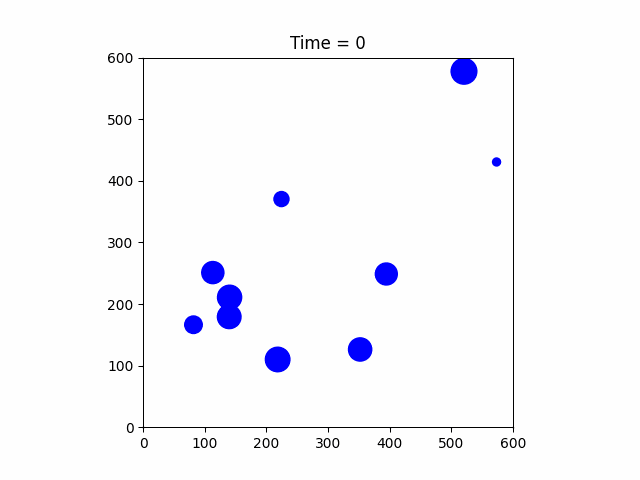

In [7]:
simulation_to_gif(simulation_data, env_size=env_size, skip_frames=1)

In [8]:
def simulate_planetary_system(bodies_dict, steps, dt):
    space = pymunk.Space()
    space.gravity = (0, 0)  # No global gravity, we'll compute gravitational forces manually.

    pymunk_bodies = {}
    positions = {}

    # Create celestial bodies
    for name, attrs in bodies_dict.items():
        mass = attrs['mass']
        radius = attrs['radius']
        position = attrs['position']
        velocity = attrs['velocity']

        inertia = pymunk.moment_for_circle(mass, 0, radius)
        p_body = pymunk.Body(mass, inertia)
        p_body.position = pymunk.Vec2d(position[0], position[1])
        p_body.velocity = pymunk.Vec2d(velocity[0], velocity[1])
        shape = pymunk.Circle(p_body, radius)
        space.add(p_body, shape)

        pymunk_bodies[name] = p_body
        positions[name] = []

    # Simulation loop
    for _ in range(steps):
        # Update gravitational forces
        for body_i_name, body_i in pymunk_bodies.items():
            for body_j_name, body_j in pymunk_bodies.items():
                if body_i_name != body_j_name:
                    force_direction = body_j.position - body_i.position
                    distance = force_direction.length
                    force_magnitude = 6.67430e-11 * body_i.mass * body_j.mass / (distance ** 2)
                    force = force_direction.normalized() * force_magnitude
                    body_i.apply_force_at_local_point(force, (0, 0))
        
        space.step(dt)

        # Store positions for graphing
        for name, body in pymunk_bodies.items():
            positions[name].append(tuple(body.position))

    return positions

In [9]:
def plot_orbits(positions):
    fig, ax = plt.subplots()
    for name, trajectory in positions.items():
        x, y = zip(*trajectory)
        ax.plot(x, y, label=name)
    
    ax.set_aspect('equal')
    ax.set_xlabel('X position (meters)')
    ax.set_ylabel('Y position (meters)')
    ax.legend()
    plt.title('Planetary Orbits')
    plt.show()

In [10]:
def calculate_env_size_from_positions(positions, buffer_factor=1.2):
    max_x = max_y = -float('inf')
    min_x = min_y = float('inf')

    for trajectory in positions.values():
        for (x, y) in trajectory:
            max_x = max(max_x, x)
            max_y = max(max_y, y)
            min_x = min(min_x, x)
            min_y = min(min_y, y)

    # Calculate the center of the extents
    center_x = (max_x + min_x) / 2
    center_y = (max_y + min_y) / 2

    # Calculate the maximum distance from the center to the extents
    max_distance_from_center = max(max_x - center_x, max_y - center_y, center_x - min_x, center_y - min_y)

    # Apply buffer factor to ensure all objects are within the frame and there's extra space around the edges
    env_size = max_distance_from_center * buffer_factor
    return env_size, (center_x, center_y)


def planetary_simulation_to_gif(positions, env_size, center, filename='planetary_simulation.gif', skip_frames=1):
    # Create a folder to store images temporarily
    if not os.path.exists('frames'):
        os.makedirs('frames')
    
    images = []
    # Plot each frame and save as an image
    for index in range(0, len(next(iter(positions.values()))), skip_frames):
        fig, ax = plt.subplots()
        ax.set_xlim(center[0] - env_size, center[0] + env_size)
        ax.set_ylim(center[1] - env_size, center[1] + env_size)
        ax.set_aspect('equal')

        # Plot trails and current positions
        for key, trajectory in positions.items():
            x, y = zip(*trajectory[:index + 1])
            ax.plot(x, y, '-', markersize=2, linewidth=1, color='gray')
            if len(x) > 0:
                ax.plot(x[-1], y[-1], 'o', color='blue')
                ax.text(x[-1], y[-1], ' ' + key, fontsize=9, verticalalignment='center')

        ax.set_title(f'Time Step = {index * skip_frames}')
        
        # Save each plot as an image file
        frame_filename = f'frames/frame_{index:04d}.png'
        plt.savefig(frame_filename)
        plt.close(fig)
        images.append(imageio.imread(frame_filename))
    
    # Create GIF with loop=0 for infinite loop
    imageio.mimsave(filename, images, duration=0.1, loop=0)
    
    # Clean up frames
    for frame_file in os.listdir('frames'):
        os.remove(os.path.join('frames', frame_file))
    os.rmdir('frames')

    # Display the GIF in the notebook as a base64 image
    with open(filename, 'rb') as f:
        image_data = f.read()
        b64 = base64.b64encode(image_data).decode('utf-8')
        display(Image(url=f"data:image/gif;base64,{b64}"))

## Earth and Moon

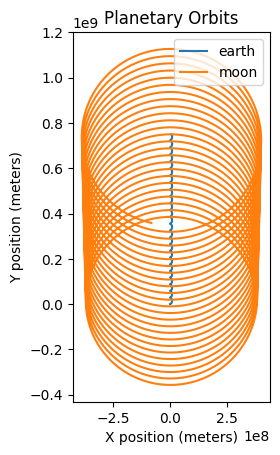

In [11]:
# Example initial conditions
bodies = {
    'earth': {'mass': 5.972e24, 'radius': 100, 'position': (0, 0), 'velocity': (0, 0)},  # A large central body (like Earth)
    'moon': {'mass': 7.348e22, 'radius': 30, 'position': (384400000, 0), 'velocity': (0, 1022)}  # A smaller body (like the Moon)
}

timesteps = int(1e6)
positions = simulate_planetary_system(bodies, timesteps, 60)
plot_orbits(positions)

In [12]:
int(len(positions['earth'])/100)

10000


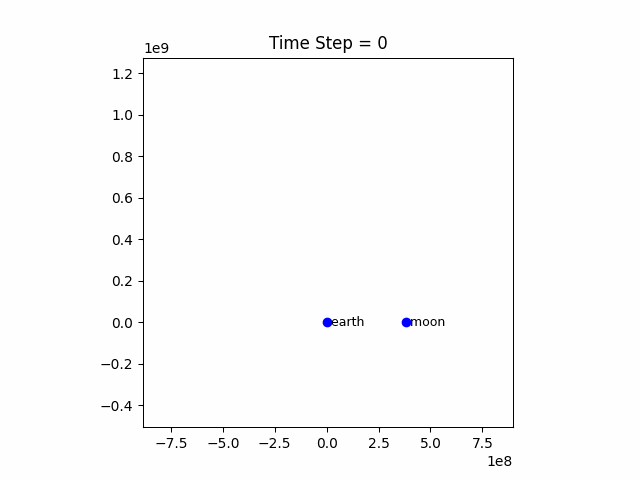

In [13]:
skip = int(len(positions['earth'])/60)
env_size, center = calculate_env_size_from_positions(positions)
planetary_simulation_to_gif(positions, env_size=env_size, center=center, filename='twobody.gif', skip_frames=skip)

## 3-body simulation

In [14]:
# def generate_three_body_initial_conditions():
#     AU = 150e6 * 1000  # 1 Astronomical Unit in meters
#     moon_distance = 0.384e6 * 1000 *10  # Moon distance from Earth in meters

#     # Sun
#     sun = {
#         'mass': 1.989e30,  # Mass of the Sun in kilograms
#         'radius': 696340 * 1000,  # Radius of the Sun in meters
#         'position': (0, 0),
#         'velocity': (0, 0)
#     }

#     # Earth
#     earth = {
#         'mass': 5.972e24 *10,  # Mass of the Earth in kilograms
#         'radius': 6371 * 1000,  # Radius of the Earth in meters
#         'position': (AU, 0),
#         'velocity': (0, 29.78 * 1000)  # Orbital velocity in m/s
#     }

#     # Moon
#     moon = {
#         'mass': 7.348e22,  # Mass of the Moon in kilograms
#         'radius': 1737 * 1000,  # Radius of the Moon in meters
#         'position': (AU + moon_distance, 0),
#         'velocity': (0, 29.78 * 1000 + 1022)  # Orbital velocity in m/s
#     }

#     return {'sun': sun, 'earth': earth, 'moon': moon}

def generate_three_body_initial_conditions():
    # Constants (not to scale, simplified for visualization)
    AU = 149.6e6 * 1000     # 1 Astronomical Unit in meters
    moon_distance = 384400  # Moon distance from Earth in kilometers, much reduced for scale

    # Sun: Located at the origin
    sun = {
        'mass': 1.989e30,  # Mass of the Sun in kilograms
        'radius': 696340 * 100,  # Radius of the Sun in kilometers, not to scale
        'position': (0, 0),
        'velocity': (0, 0)
    }

    # Earth: 1 AU from the Sun on the x-axis
    earth = {
        'mass': 5.972e24,  # Mass of the Earth in kilograms
        'radius': 6371 * 10,  # Radius of the Earth in kilometers, not to scale
        'position': (AU, 0),
        'velocity': (0, 29.78 * 1000)  # Orbital velocity of Earth around the Sun in m/s
    }

    # Moon: 384400 km from Earth on the x-axis (simplified)
    moon = {
        'mass': 7.348e22,  # Mass of the Moon in kilograms
        'radius': 1737 * 10,  # Radius of the Moon in kilometers, not to scale
        'position': (AU + moon_distance * 1000, 0),
        'velocity': (0, 29.78 * 1000 + 1022)  # Sum of Earth's orbital velocity and Moon's orbital speed around Earth
    }

    return {'sun': sun, 'earth': earth, 'moon': moon}

In [15]:
# three_bodies_positions

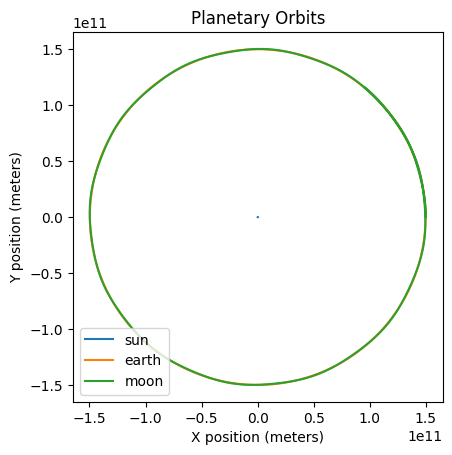

In [18]:
three_bodies = generate_three_body_initial_conditions()
timesteps = int(6e5)
three_bodies_positions = simulate_planetary_system(three_bodies, timesteps, 60)
plot_orbits(three_bodies_positions)


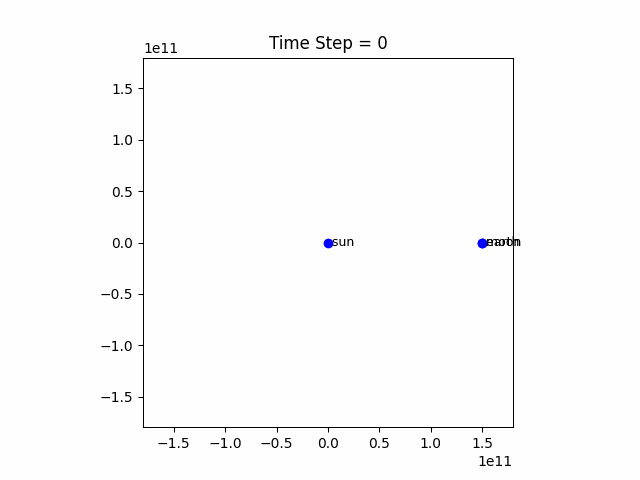

In [19]:
skip = int(len(three_bodies_positions['earth'])/50)
env_size, center= calculate_env_size_from_positions(three_bodies_positions)
planetary_simulation_to_gif(three_bodies_positions, env_size=env_size, center=center, filename='threebody.gif', skip_frames=skip)

In [20]:
def planetary_simulation_to_gif_earthmoon(
    positions, 
    env_size, 
    center, 
    filename='threebody.gif', 
    skip_frames=1, 
    focus_bodies=['earth', 'moon']
):
    # Create a folder to store images temporarily
    if not os.path.exists('frames'):
        os.makedirs('frames')
    
    images = []
    # Plot each frame and save as an image
    for index in range(0, len(positions['earth']), skip_frames):  # Assuming Earth's trajectory length can represent the range
        fig, ax = plt.subplots()
        
        # Calculate the current center based on the positions of focus bodies
        current_x = sum(positions[body][index][0] for body in focus_bodies) / len(focus_bodies)
        current_y = sum(positions[body][index][1] for body in focus_bodies) / len(focus_bodies)
        ax.set_xlim(current_x - env_size/2, current_x + env_size/2)
        ax.set_ylim(current_y - env_size/2, current_y + env_size/2)
        ax.set_aspect('equal')  # Ensures that circle remains circular

        # Plot trails and current positions
        for key, trajectory in positions.items():
            x, y = zip(*trajectory[:index + 1])
            ax.plot(x, y, '-', markersize=2, linewidth=1, color='gray')  # Plot path as a line
            if len(x) > 0:
                ax.plot(x[-1], y[-1], 'o', color='blue')  # Plot current position as a dot
                ax.text(x[-1], y[-1], ' ' + key, fontsize=9, verticalalignment='center')  # Label the body

        ax.set_title(f'Time Step = {index * skip_frames}')
        
        # Save each plot as an image file
        frame_filename = f'frames/frame_{index:04d}.png'
        plt.savefig(frame_filename)
        plt.close(fig)
        images.append(imageio.imread(frame_filename))
    
    # Create GIF with loop=0 for infinite loop
    imageio.mimsave(filename, images, duration=0.1, loop=0)
    
    # Clean up frames
    for frame_file in os.listdir('frames'):
        os.remove(os.path.join('frames', frame_file))
    os.rmdir('frames')

    # Display the GIF in the notebook as a base64 image
    with open(filename, 'rb') as f:
        image_data = f.read()
        b64 = base64.b64encode(image_data).decode('utf-8')
        display(Image(url=f"data:image/gif;base64,{b64}"))

In [24]:
env_size, center= calculate_env_size_from_positions(three_bodies_positions)
env_size

179868367585.31946


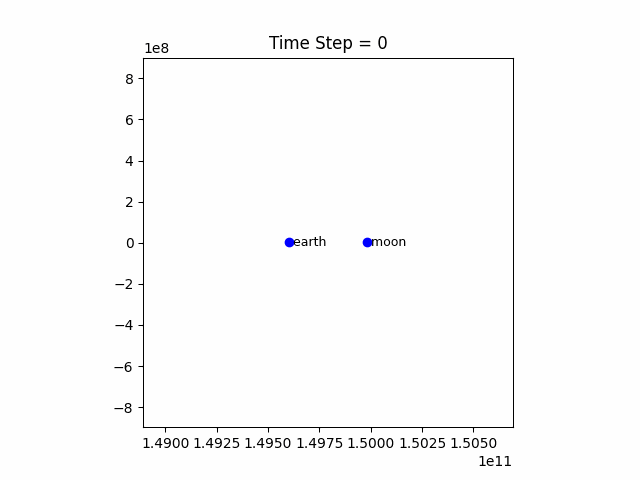

In [28]:
skip = int(len(three_bodies_positions['earth'])/200)
env_size, center= calculate_env_size_from_positions(three_bodies_positions)
env_size = env_size/100
center = (0,0)
planetary_simulation_to_gif_earthmoon(three_bodies_positions, env_size=env_size, center=center, filename='threebodyearthmoon.gif', skip_frames=skip)